In [15]:
import pandas as pd
import BidirectionalStepwiseSelection as ss


import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('final_data.csv',index_col='Unnamed: 0',parse_dates=True)

In [3]:
df.tail()

,FIRST,HIGH,LOW,CLOSE,VALUE,VOL,OPENINT,OPEN,LAST,Overall_Index,Top_50_Index,Industy_Index,RSI_14D
1397-12-13,1249.0,1259.0,1224.0,1236.0,72074053563,58320975,3004,1232.0,1225.0,164238.6,7016.1,147424.0,51.494211
1397-12-14,1236.0,1236.0,1185.0,1209.0,55705654482,46078691,2373,1236.0,1185.0,162593.6,6937.3,145976.0,45.004217
1397-12-15,1213.0,1229.0,1170.0,1194.0,77233097825,64657910,3228,1209.0,1200.0,162827.3,6950.6,146165.0,47.667827
1397-12-18,1210.0,1210.0,1158.0,1165.0,62324686318,53509948,3218,1194.0,1159.0,163007.3,6959.9,146355.0,41.719946
1397-12-19,1160.0,1203.0,1149.0,1187.0,137201316315,115549687,5852,1165.0,1193.0,164470.4,7027.6,147749.0,47.563176


In [4]:
X = df.drop(['CLOSE'],axis=1)
y = df['CLOSE']
final_vars, iterations_logs = ss.BidirectionalStepwiseSelection(X,y, model_type="linear")

# Write Logs To .txt
iterations_file = open("Iterations_logs_S.txt","w+") 
iterations_file.write(iterations_logs)
iterations_file.close()

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : FIRST 	AIC : 14255.121120318556
break : No need to Backward Elimination
Entered : LAST 	AIC : 12976.87131922883
break : No need to Backward Elimination
Entered : OPEN 	AIC : 12655.18721906074
break : No need to Backward Elimination
Entered : LOW 	AIC : 12595.026449814268
break : No need to Backward Elimination
Entered : HIGH 	AIC : 12525.312201726076
break : No need to Backward Elimination
Entered : Overall_Index 	AIC : 12515.773844918058
break : No need to Backward Elimination
Entered : VALUE 	AIC : 12503.637378312496
break : No need to Backward Elimination
Entered : VOL 	AIC : 12487.335722223226
break : No need to Backward Elimination
Entered : Top_50_Index 	AIC : 12476.657117654006
Break : Significance Level
                                 OLS Regression Results                                
Dep. Variable:                  CLOSE   R-squared (uncentered):           

In [5]:
print('There are {} number of days in dataset.'.format(df.shape[0]))

There are 1631 number of days in dataset.


In [6]:
train = df.loc['1389-01-01':'1394-01-01',['CLOSE','LAST', 'OPEN', 'LOW', 'HIGH', 'Overall_Index', 'VALUE', 'VOL', 'Top_50_Index']]
val = df.loc['1394-01-01':'1396-07-01',['CLOSE','LAST', 'OPEN', 'LOW', 'HIGH', 'Overall_Index', 'VALUE', 'VOL', 'Top_50_Index']]
test = df.loc['1396-07-01':'1398-01-01',['CLOSE','LAST', 'OPEN', 'LOW', 'HIGH', 'Overall_Index', 'VALUE', 'VOL', 'Top_50_Index']]
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)


In [7]:
print(train.shape, val.shape, test.shape)

(1086, 9) (320, 9) (225, 9)


In [8]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [12]:
def fit_model_GRU(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [9]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []
    mse = []
    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
    #return mse

In [10]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,title):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate_LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [11]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [13]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 500

Epoch 00163: early stopping


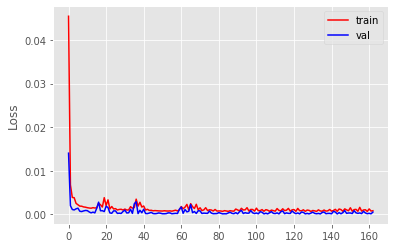

In [16]:
model,train_error,val_error = fit_model_GRU(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0006415954722290584
RMSE = 0.025329734941942413
R-Squared Score = 0.9606251079539545


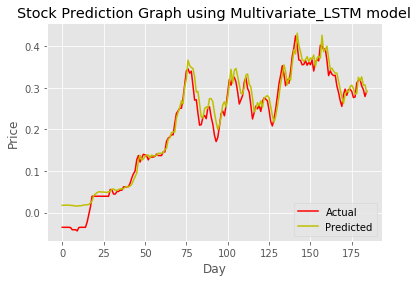

In [17]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted,'Multivariate_GRU')

In [18]:
# Save a model
model.save('models/MV3-GRU_40_[40,35]_1e-3_64.h5')
#del model # Deletes the model
# Load a model
#model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')